In [120]:
%matplotlib inline

import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt # matplotlib
import seaborn as sns           # seaborn

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

pd.set_option('display.max_columns', None)

np.random.seed(2131) # set random seed

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load data files
teams               = pd.read_csv('../data/Teams.csv')
seasons             = pd.read_csv('../data/Seasons.csv')
reg_season_compact  = pd.read_csv('../data/RegularSeasonCompactResults.csv')
reg_season_detailed = pd.read_csv('../data/RegularSeasonDetailedResults.csv')
tourney_compact     = pd.read_csv('../data/TourneyCompactResults.csv')
tourney_detailed    = pd.read_csv('../data/TourneyDetailedResults.csv')
tourney_seeds       = pd.read_csv('../data/TourneySeeds.csv')
tourney_slots       = pd.read_csv('../data/TourneySlots.csv')

** Let's see how the performance of the team varies as we progress into the season. **

In [4]:
def get_team_performance(detailed_season, team_id):
    wmask = (detailed_season.Wteam == team_id)
    lmask = (detailed_season.Lteam == team_id)
    
    winning_instances = detailed_season.loc[wmask, ['Season', 'Daynum']]
    winning_instances['outcome'] = np.array([1] * len(winning_instances)) 
    
    losing_instances  = detailed_season.loc[lmask, ['Season', 'Daynum']]
    losing_instances['outcome'] = np.array([0] * len(losing_instances))
    
    instances_concat = pd.concat((winning_instances, losing_instances))
    instances_concat_sorted = instances_concat.sort_values(by=['Season','Daynum'])
    
    return instances_concat_sorted  

In [5]:
reg_season_detailed.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,Wfgm3,Wfga3,Wftm,Wfta,Wor,Wdr,Wast,Wto,Wstl,Wblk,Wpf,Lfgm,Lfga,Lfgm3,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [6]:
def get_season_perforamce(performance, season):
    mask = performance.Season == season
    return performance.loc[mask, ['Daynum', 'outcome']]

In [7]:
def performance_across_seasons(performance, seasons):
    dim = int(np.ceil(len(seasons) ** 0.5))
    fig, axes = plt.subplots(nrows=dim, ncols=dim, figsize=(15, 15))
    
    for i, season in enumerate(seasons):
        season_perf = get_season_perforamce(performance, season)
        sns.regplot(x='Daynum',
                    y='outcome',
                    data=season_perf,
                    fit_reg=False,
                    ax=axes[i//dim][i%dim]
                   )
        axes[i//dim][i%dim].set_title('Season: %s'%(season))
    
    plt.tight_layout();

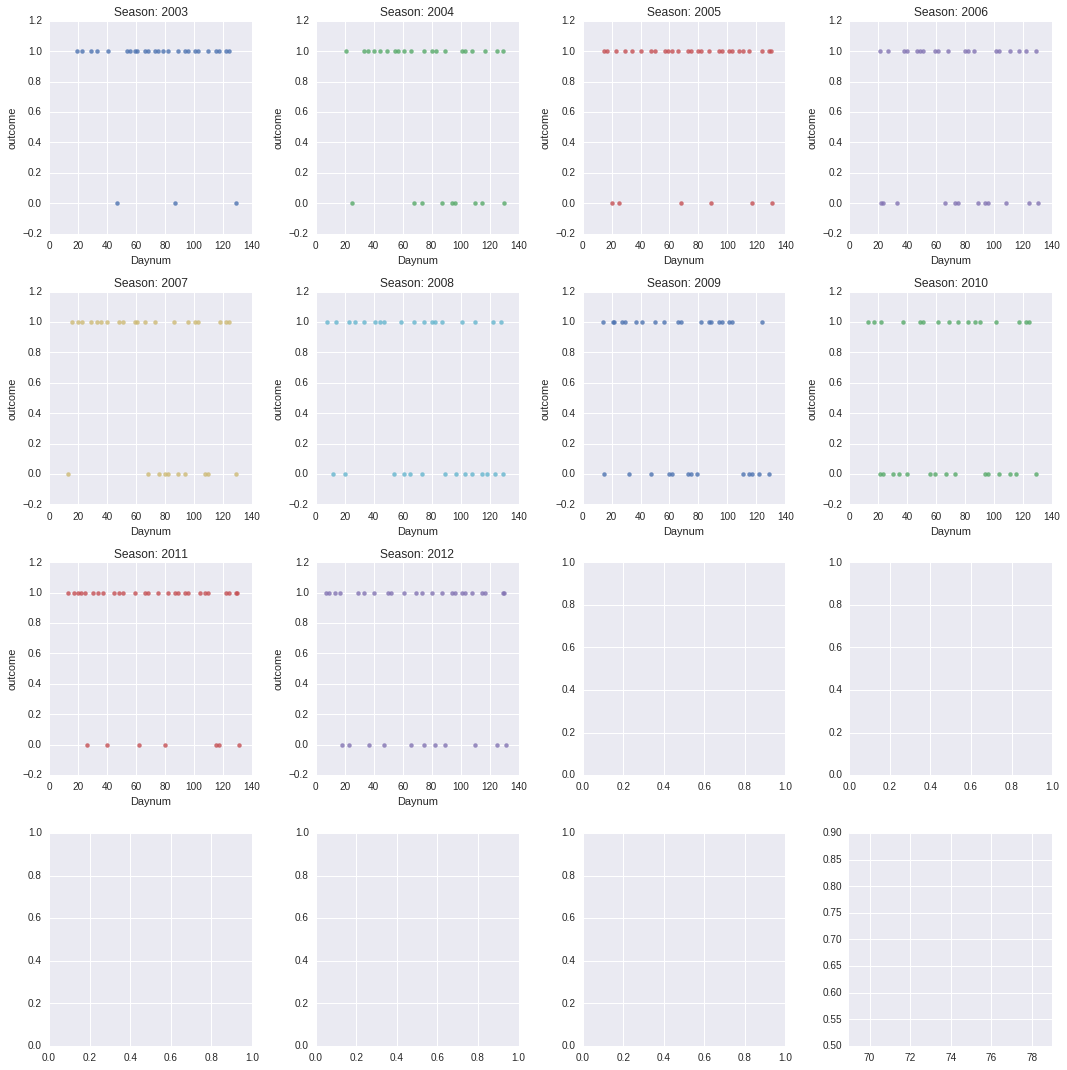

In [79]:
team_performance = get_team_performance(reg_season_detailed, 1112)
performance_across_seasons(team_performance, np.arange(2003, 2013))

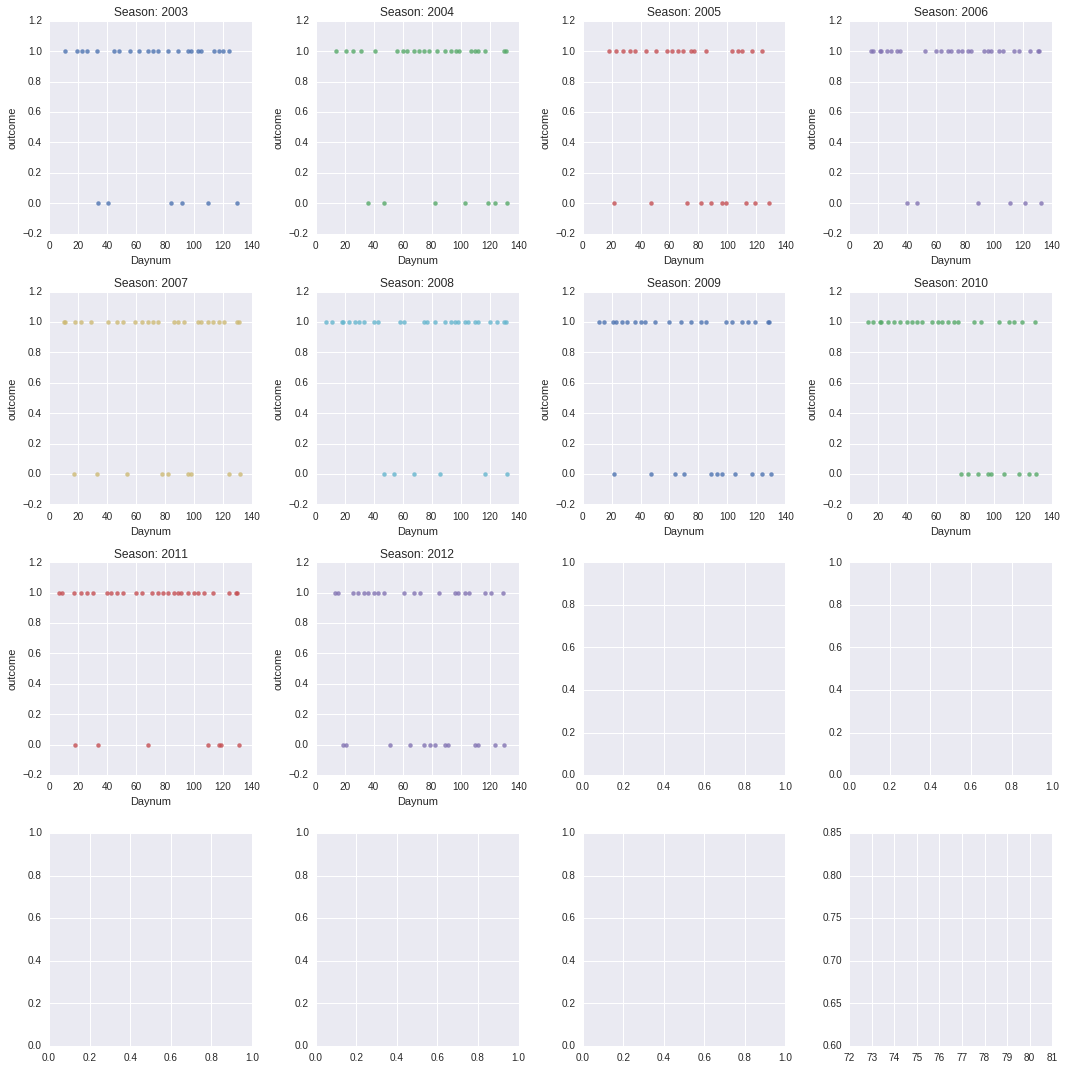

In [77]:
team_performance = get_team_performance(reg_season_detailed, 1400)
performance_across_seasons(team_performance, np.arange(2003, 2013))

In [78]:
tourney_detailed.loc[(tourney_detailed.Season == 2011) &
                     ((tourney_detailed.Wteam == 1400) |
                      (tourney_detailed.Lteam == 1400)
                     ), :
                    ]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,Wfgm3,Wfga3,Wftm,Wfta,Wor,Wdr,Wast,Wto,Wstl,Wblk,Wpf,Lfgm,Lfga,Lfgm3,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
545,2011,137,1400,85,1324,81,N,0,30,63,4,9,21,26,15,27,14,10,4,9,14,33,75,7,29,8,11,17,21,12,7,7,3,17
556,2011,139,1112,70,1400,69,N,0,24,54,8,14,14,22,11,21,17,12,8,2,20,24,53,3,11,18,22,10,23,13,13,5,7,17


** Is there any relationship between recent form in regular season and performance in tournament ? **

In [50]:
def recent_form_reg_season(season_details, season, team_id, n_days=5):
    mask  = (season_details.Season == season) & \
            ((season_details.Wteam == team_id) |\
            (season_details.Lteam == team_id)) 
    
    team_season_details        = season_details.loc[mask, :]
    team_season_details_sorted = team_season_details.sort_values(by='Daynum', ascending=False)
    recent_form                = team_season_details_sorted.iloc[:n_days]
    
    num_wins                   = len(np.where(recent_form.Wteam == team_id)[0])
    num_losses                 = len(np.where(recent_form.Lteam == team_id)[0])
    
    return (num_wins, num_losses)

def get_tournament_form(tourney_detailed, season, team_id):
    mask = (tourney_detailed.Season == season) & \
           ((tourney_detailed.Wteam == team_id))
        
    return len(tourney_detailed.loc[mask, :])

In [78]:
def rel_tournament_form_recent_form(reg_season_detailed, tourney_detailed, n_days):
    all_teams = list(set(set(tourney_detailed.Wteam.unique()) |\
                          set(tourney_detailed.Lteam.unique())))
    
    seasons         = np.arange(2004, 2016)
    form_reg_season = []
    perf_tourney    = []
    
    for team in all_teams:
        for season in seasons:
            num_wins, num_losses = recent_form_reg_season(reg_season_detailed, season, team, n_days)
            tournament_form      = get_tournament_form(tourney_detailed, season, team)

            form_reg_season.append((num_wins, num_losses))
            perf_tourney.append(tournament_form)
    
    form_reg_season = np.array(form_reg_season)
    perf_tourney = np.array(perf_tourney)
    
    return form_reg_season, perf_tourney

In [86]:
form_reg_season, perf_tourney = rel_tournament_form_recent_form(reg_season_detailed,
                                                                   tourney_detailed,
                                                                n_days=3
                                                               )

In [87]:
data = pd.DataFrame(np.hstack((form_reg_season, perf_tourney.reshape(-1, 1))))
data.columns = ['Wins', 'Losses', 'Run']

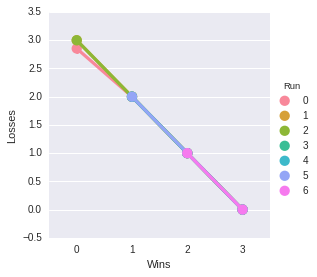

In [88]:
sns.factorplot(x='Wins', y='Losses', hue='Run', data=data);

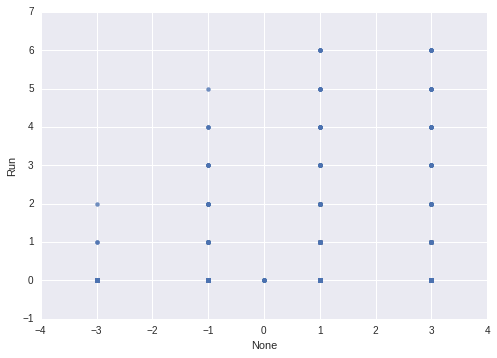

In [89]:
sns.regplot(x=data['Wins'] - data['Losses'], y=data['Run'], fit_reg=False);

** Stage - 1 **

You have to submit probabilities for all possible matchups in the past 4 NCAA tournaments. (2013 - 2016)

68 teams in the NCAA tournament are divided into first four regions and and organized into elimination _bracket_ which determines when a team wins a game, which team it will face next.

Since also all of the teams are seeded, we can use this as an indicator of the performance.

** We will look at the seeds given to the teams involved in the matchup for which we have to give out predictions. **

In [88]:
def get_tournament_seeds(tournament_seeds, season):
    """
    Given a dataframe that represents seeds given to different
    teams that took part in the NCAA tournament, return a mapping 
    between teams and their seed for that season.
    
    :param tournament_seeds: Dataframe that represent seeds for different teams
    :param season:           Year
    """
    mask  = tournament_seeds.Season == season
    
    seeds = tournament_seeds.loc[mask, :].copy()
    seeds['team_seed'] = seeds.Seed.str.findall(r'\d+').map(lambda x: int(x[0]))
    return seeds[['team_seed', 'Team']].set_index('Team').to_dict()['team_seed']

In [89]:
seeds_2012 = get_tournament_seeds(tourney_seeds, 2012)

In [52]:
# let's play with results that we have for season 2012
matchups_2012 = tourney_detailed.loc[tourney_detailed.Season == 2012, ['Wteam', 'Lteam']]

In [65]:
# let's randomly pickup up any games
train_size = int(.8 * len(matchups_2012))

# shuffle matches
shuffled_matches = matchups_2012.sample(frac=1.)
train            = shuffled_matches.iloc[:train_size]
test             = shuffled_matches.iloc[train_size:]

In [67]:
y_train = [1 if row[1][0] < row[1][1] else 0 for row in train.iterrows()]
y_test  = [1 if row[1][0] < row[1][1] else 0 for row in test.iterrows()]

In [90]:
train_seeds_2012 = np.array([[seeds_2012[row[1][0]], seeds_2012[row[1][1]]] \
                             for row in train.iterrows()])
test_seeds_2012  = np.array([[seeds_2012[row[1][0]], seeds_2012[row[1][1]]] \
                             for row in test.iterrows()])

In [93]:
log = LogisticRegression()
log.fit(train_seeds_2012, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
print('Coefficients ', log.coef_)

Coefficients  [[-0.05462418 -0.02826069]]


In [99]:
y_hat = log.predict_proba(test_seeds_2012)[:, 1]
print('Log loss score on the hidden dataset: {}'.format(log_loss(y_test, y_hat)))

Log loss score on the hidden dataset: 0.7348481361865284


** Let' see what is the performance of this model across different tournaments. ** 

In [169]:
def seed_model(tourney_compact, tournament_seeds, seasons):
    for season in seasons:
        seeds_season    = get_tournament_seeds(tourney_seeds, season)
        matchups_season = tourney_compact.loc[tourney_compact.Season == season, ['Wteam', 'Lteam']]
        
        # let's randomly pickup up any games
        train_size = int(.7 * len(matchups_season))

        # shuffle matches
        shuffled_matches = matchups_season.sample(frac=1.)
        train            = shuffled_matches.iloc[:train_size]
        test             = shuffled_matches.iloc[train_size:]
        
        y_train = [1 if row[1][0] < row[1][1] else 0 for row in train.iterrows()]
        y_test  = [1 if row[1][0] < row[1][1] else 0 for row in test.iterrows()]
        
        train_seeds_season = []
        
        for idx, row in train.iterrows():
            if row[0] < row[1]:
                train_seeds_season.append([seeds_season[row[0]], seeds_season[row[1]]])
            else:
                train_seeds_season.append([seeds_season[row[1]], seeds_season[row[0]]])
        
        train_seeds_season = np.array(train_seeds_season)
        
        
        test_seeds_season = []
        
        for idx, row in test.iterrows():
            if row[0] < row[1]:
                test_seeds_season.append([seeds_season[row[0]], seeds_season[row[1]]])
            else:
                test_seeds_season.append([seeds_season[row[1]], seeds_season[row[0]]])
        
        test_seeds_season = np.array(test_seeds_season)
                
        diff_seeds_train = (train_seeds_season[:, 0] - train_seeds_season[:, 1]).reshape(-1, 1)
        diff_seeds_test = (test_seeds_season[:, 0] - test_seeds_season[:, 1]).reshape(-1, 1)

        print('Season :', season)
        
        log = LogisticRegression(C=.1) # linear model
#         rf  = RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=1313) # non-linear model
        
        log.fit(diff_seeds_train, y_train)

        print('Coefficients ', log.coef_)
        
        y_hat = log.predict_proba(diff_seeds_test)[:, 1]
        print('Log loss score on the hidden dataset: {}'.format(log_loss(y_test, y_hat)))
        print('-'*75)

In [170]:
seed_model(tourney_compact, tourney_seeds, np.arange(2003, 2017))

Season : 2003
Log loss score on the hidden dataset: 2.331776011876463
---------------------------------------------------------------------------
Season : 2004
Log loss score on the hidden dataset: 0.672644434201955
---------------------------------------------------------------------------
Season : 2005
Log loss score on the hidden dataset: 2.103966941072681
---------------------------------------------------------------------------
Season : 2006
Log loss score on the hidden dataset: 0.5107650647319044
---------------------------------------------------------------------------
Season : 2007
Log loss score on the hidden dataset: 3.5809197662690706
---------------------------------------------------------------------------
Season : 2008
Log loss score on the hidden dataset: 0.672876392080157
---------------------------------------------------------------------------
Season : 2009
Log loss score on the hidden dataset: 0.36010006572619196
--------------------------------------------------

In [166]:
def get_predictions(tourney_compact, tournament_seeds, sub, seasons):
    models = {}
    
    for season in seasons:
        seeds_season    = get_tournament_seeds(tourney_seeds, season)
        matchups_season = tourney_compact.loc[tourney_compact.Season == season, ['Wteam', 'Lteam']]
        
        outcome = [1 if row[0] < row[1] else 0 for idx, row in matchups_season.iterrows()]
        
        feature_seeds = []
        
        for idx, row in matchups_season.iterrows():
            if row[0] < row[1]:
                feature_seeds.append([seeds_season[row[0]], seeds_season[row[1]]])
            else:
                feature_seeds.append([seeds_season[row[1]], seeds_season[row[0]]])
        
        feature_seeds = np.array(feature_seeds)
        diff_seeds = (feature_seeds[:, 0] - feature_seeds[:, 1]).reshape(-1, 1)

        model = RandomForestClassifier(n_jobs=-1, random_state=1313)
        model.fit(diff_seeds, outcome)
        
        models[season] = model
    
    predictions = []
    
    for idx, row in sub.iterrows():
        season, team_1, team_2 = row['id'].split('_')
        season = int(season)
        team_1 = int(team_1)
        team_2 = int(team_2)
        
        seeds_season  = get_tournament_seeds(tourney_seeds, season)
        
        feature_seeds = np.array([[seeds_season[team_1], seeds_season[team_2]]])
        diff_seeds    = (feature_seeds[:, 0] - feature_seeds[:, 1]).reshape(-1, 1)
        
        y_hat = models[season].predict_proba(diff_seeds)[:, 1]
        predictions.append(y_hat)
    
    return predictions

In [149]:
predictions = get_predictions(tourney_compact, tourney_seeds, sub, np.arange(2013, 2017))

In [161]:
predictions = np.array(predictions).reshape(-1, )

In [162]:
sub = pd.read_csv('../data/sample_submission.csv')

In [163]:
sub['pred'] = predictions

In [165]:
sub.to_csv('../submissions/seed_based_predictions.csv', index=False)